In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("diabetes.csv", sep = ",")

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


# EDA

In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


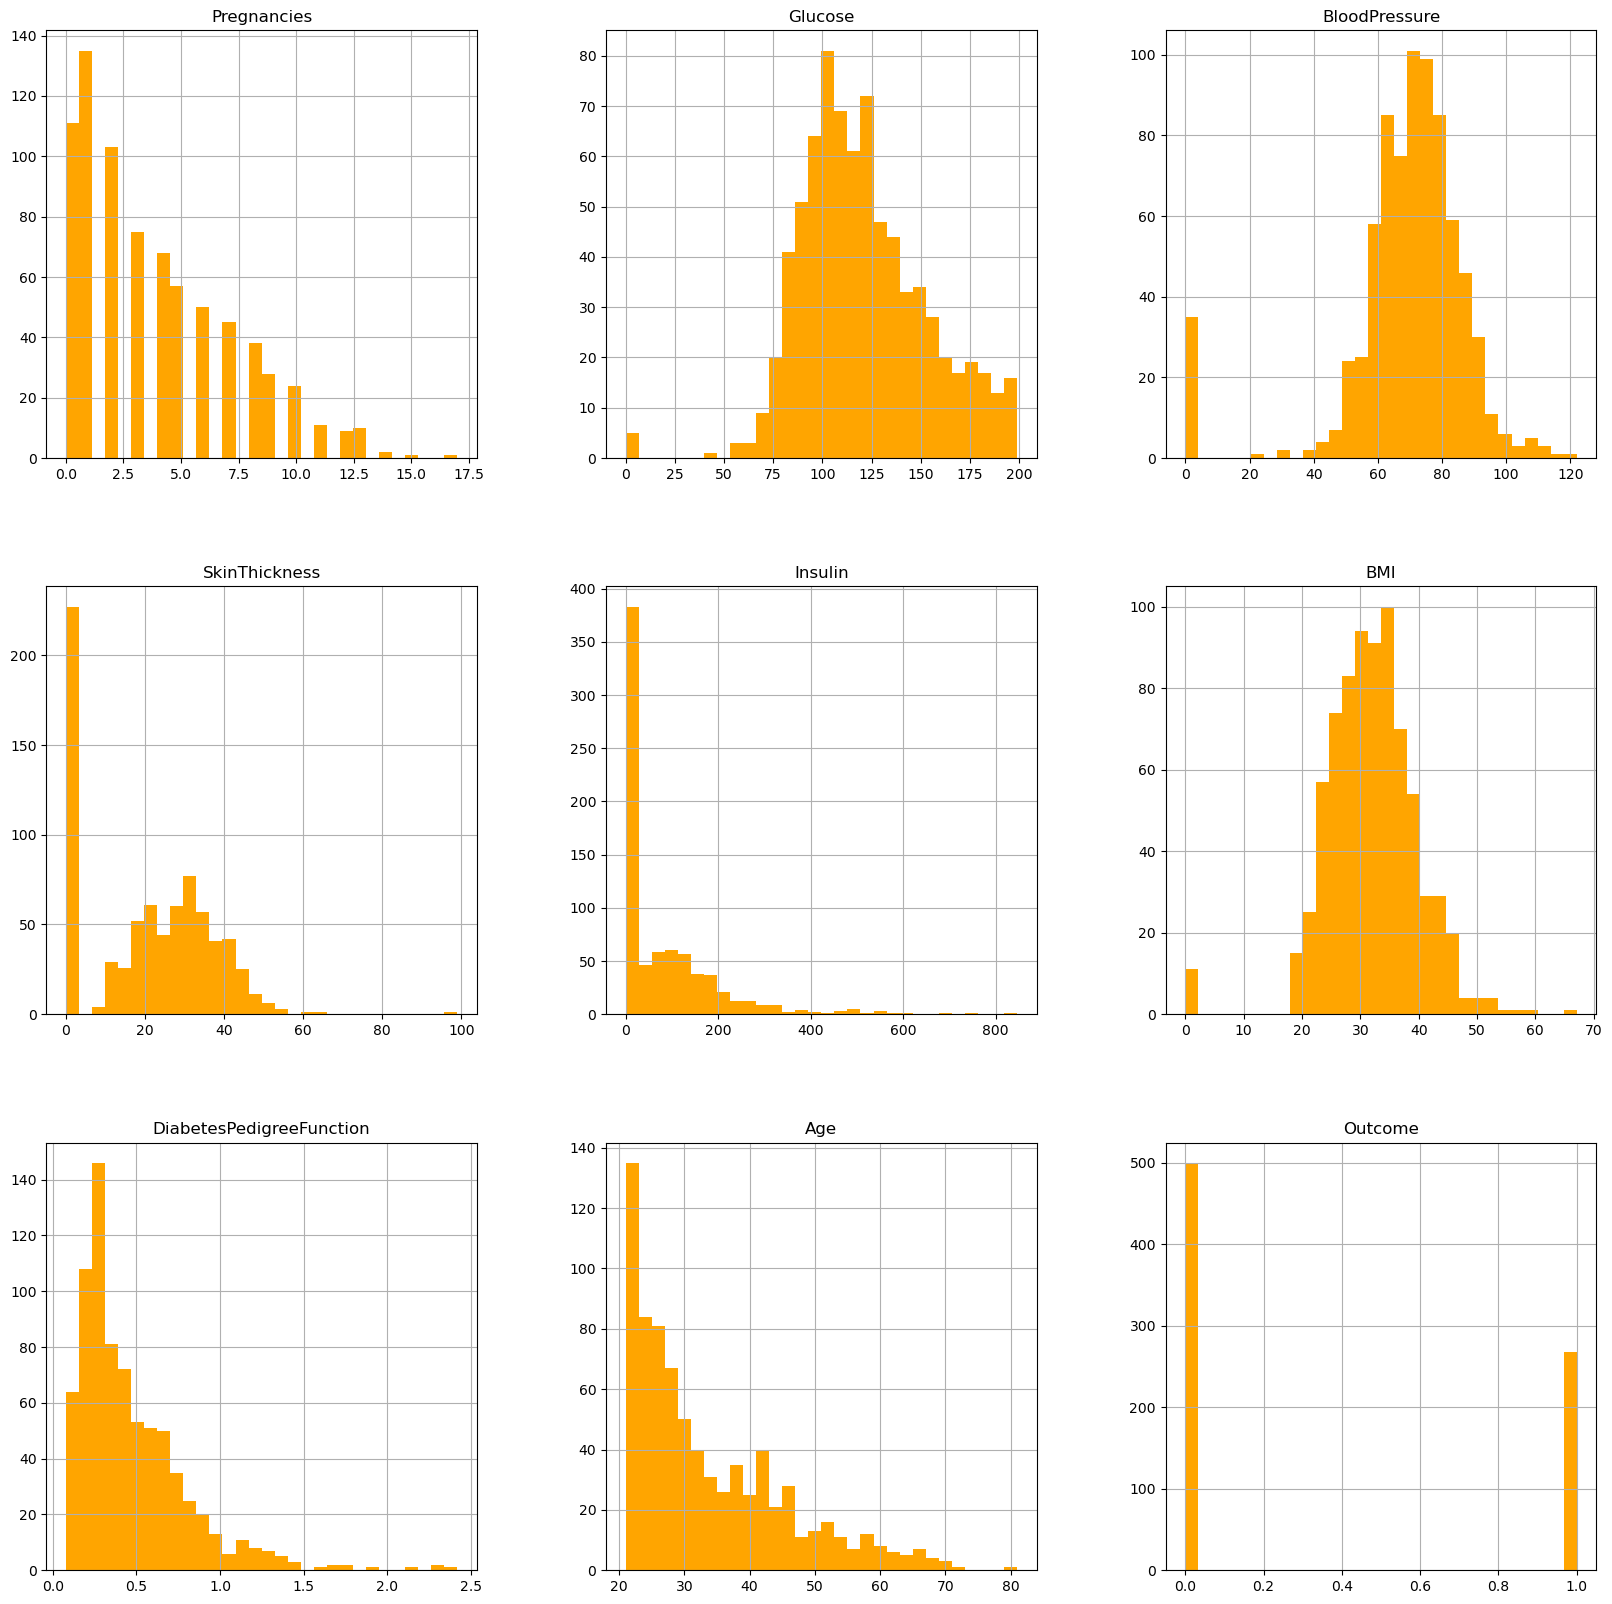

In [5]:
df.hist(bins = 30, figsize = (20, 20), color = 'orange')

plt.show()

Insights from the histograms:

* There are more young study participants.
* The zero values in the skin thickness field indicate that the collagen level was not measured for all patients. 
* Similarly, zero values for glucose, blood presure, and bmi indicate missing measurements. A glucose level of zero would mean the patient is in a coma or worse.
* There are about twice as many patients without diabetes (outcome = 0) than with diabetes (outcome = 1) 

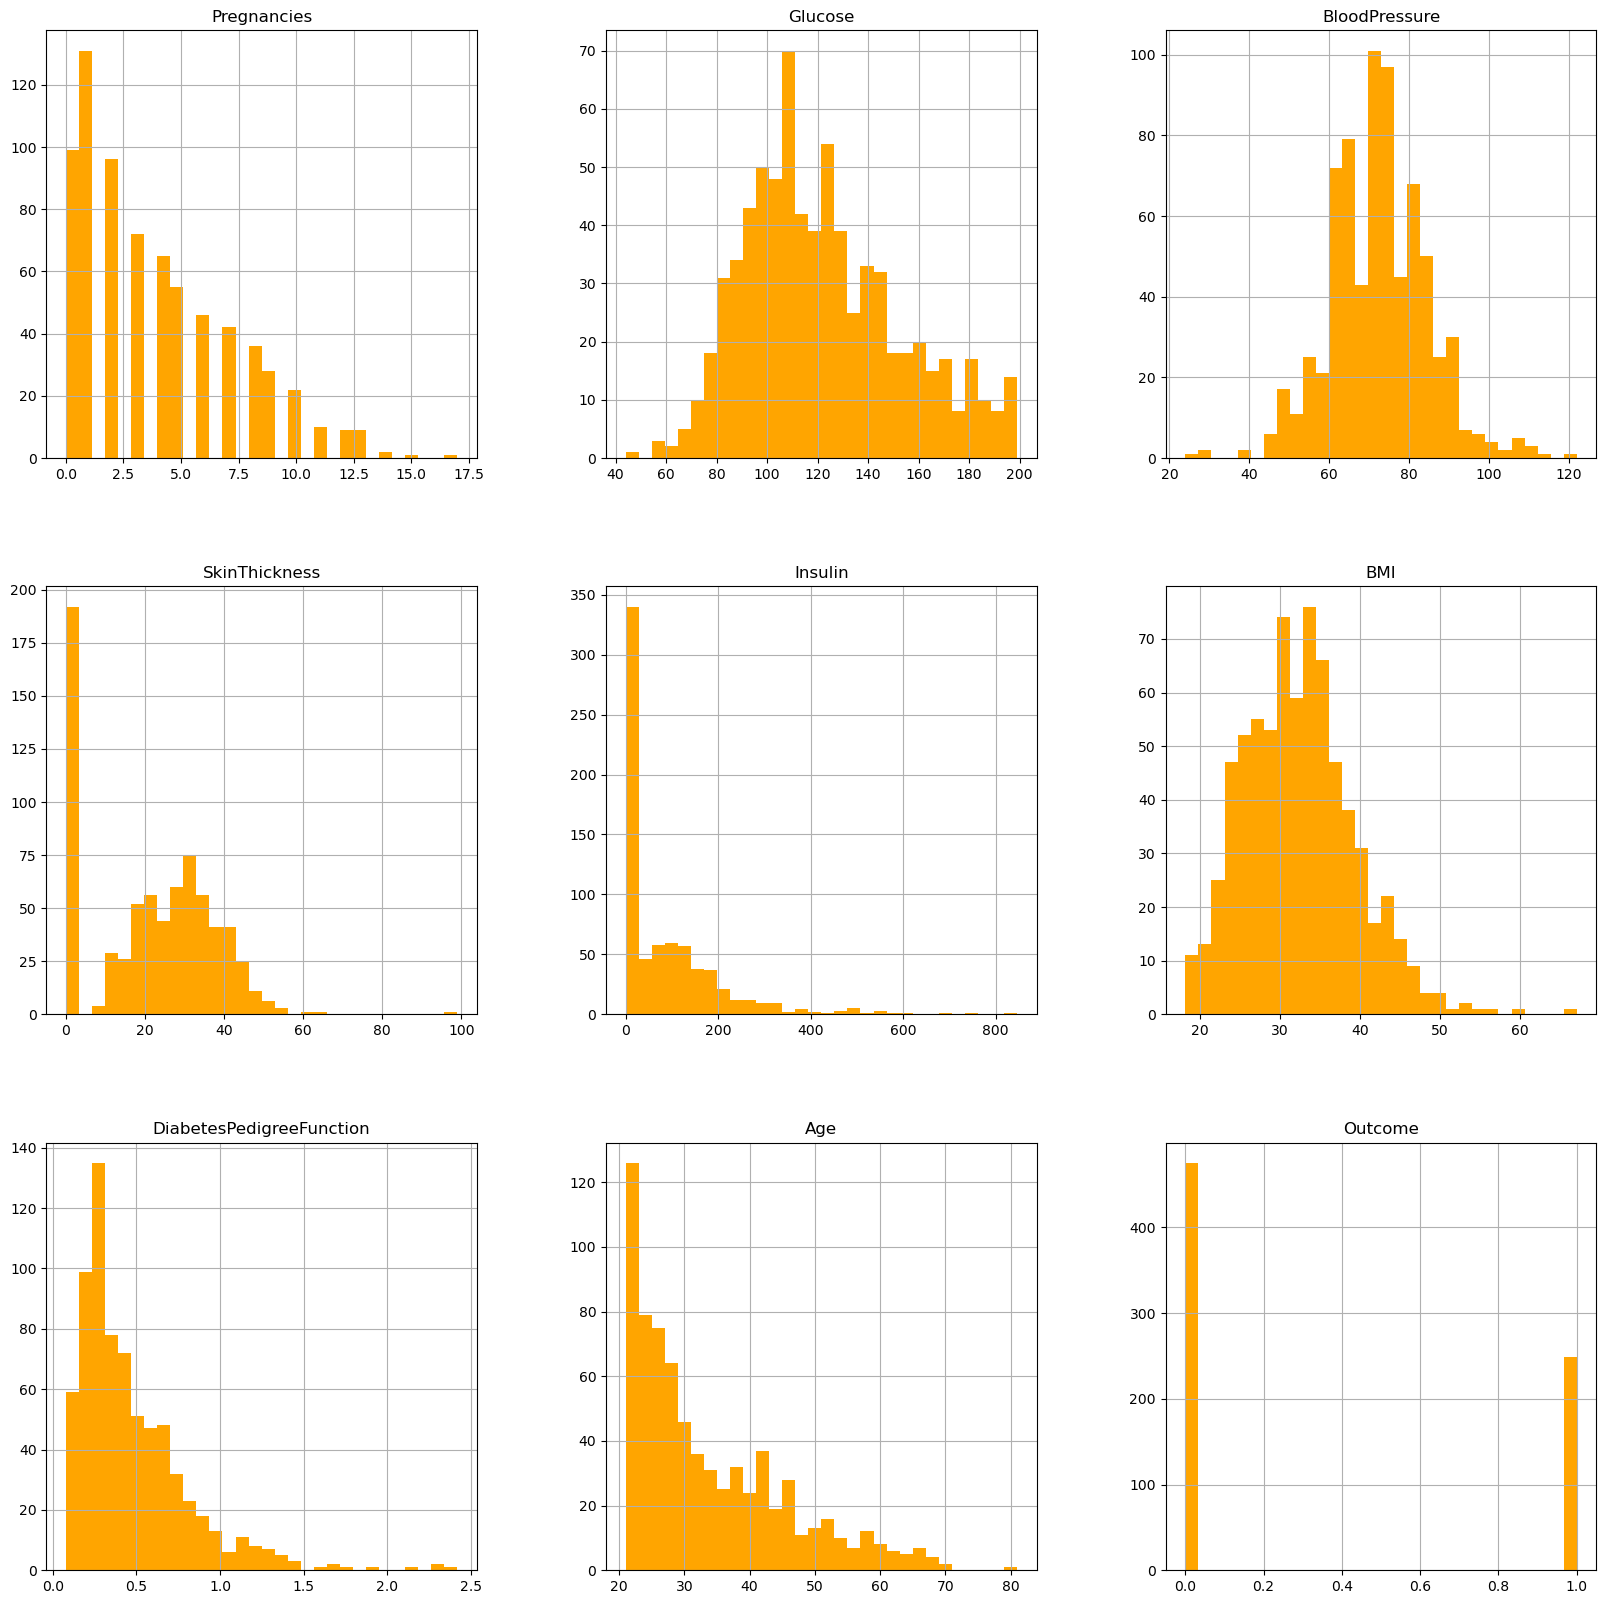

In [6]:
df = df[(df["BloodPressure"] > 0) & (df["BMI"] > 0) & (df["Glucose"] > 0)]

df.hist(bins = 30, figsize = (20, 20), color = 'orange')

plt.show()

In [7]:
# Check the number of records left after cleaning
df.shape

(724, 9)

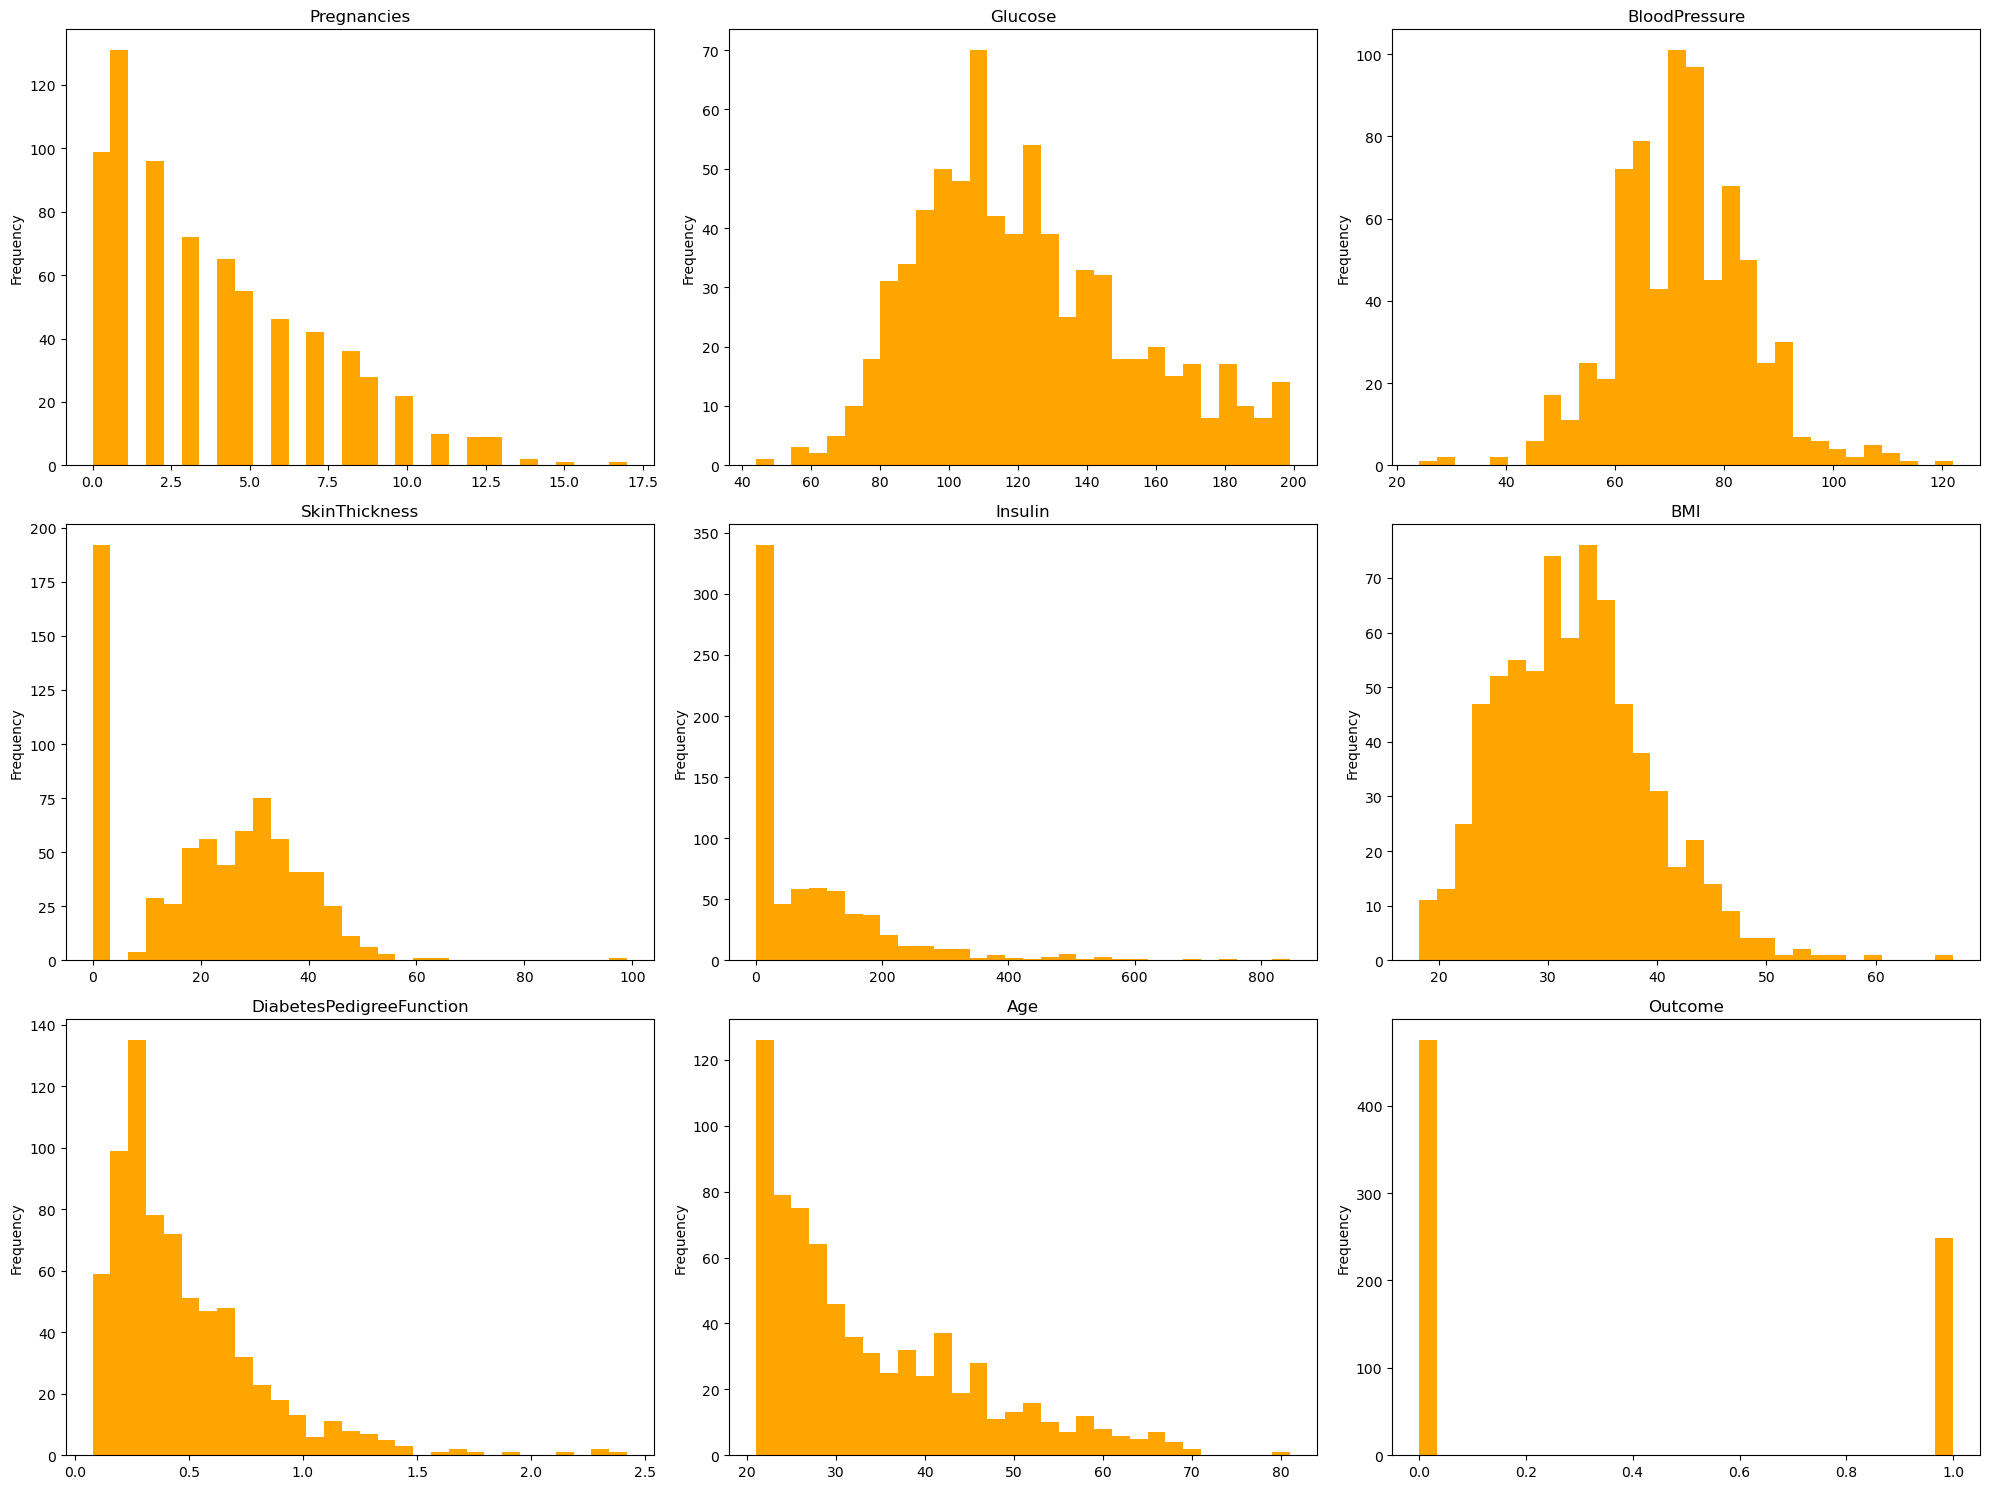

In [8]:
## Export the histograms to an image file
# Determine the number of rows and columns for subplots
num_cols = 3
num_rows = -(-len(df.columns) // num_cols)  # Ceiling division to ensure enough rows

# Create a figure and axes
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5*num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histogram for each column
for i, (col, ax) in enumerate(zip(df.columns, axes)):
    df[col].plot(kind='hist', bins=30, ax=ax, color='orange')
    ax.set_title(col)

# Remove any extra empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('img/histograms_diabetes.png')

# Show the plot
plt.show()

In [9]:
# Create a correlation matrix

corr_matrix = df.corr()

corr_matrix

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.134915,0.209668,-0.095683,-0.080059,0.012342,-0.025996,0.557066,0.224417
Glucose,0.134915,1.000000,0.223331,0.074381,0.337896,0.223276,0.136630,0.263560,0.488384
BloodPressure,0.209668,0.223331,1.000000,0.011777,-0.046856,0.287403,-0.000075,0.324897,0.166703
SkinThickness,-0.095683,0.074381,0.011777,1.000000,0.420874,0.401528,0.176253,-0.128908,0.092030
Insulin,-0.080059,0.337896,-0.046856,0.420874,1.000000,0.191831,0.182656,-0.049412,0.145488
BMI,0.012342,0.223276,0.287403,0.401528,0.191831,1.000000,0.154858,0.020835,0.299375
DiabetesPedigreeFunction,-0.025996,0.136630,-0.000075,0.176253,0.182656,0.154858,1.000000,0.023098,0.184947
Age,0.557066,0.263560,0.324897,-0.128908,-0.049412,0.020835,0.023098,1.000000,0.245741
Outcome,0.224417,0.488384,0.166703,0.092030,0.145488,0.299375,0.184947,0.245741,1.000000


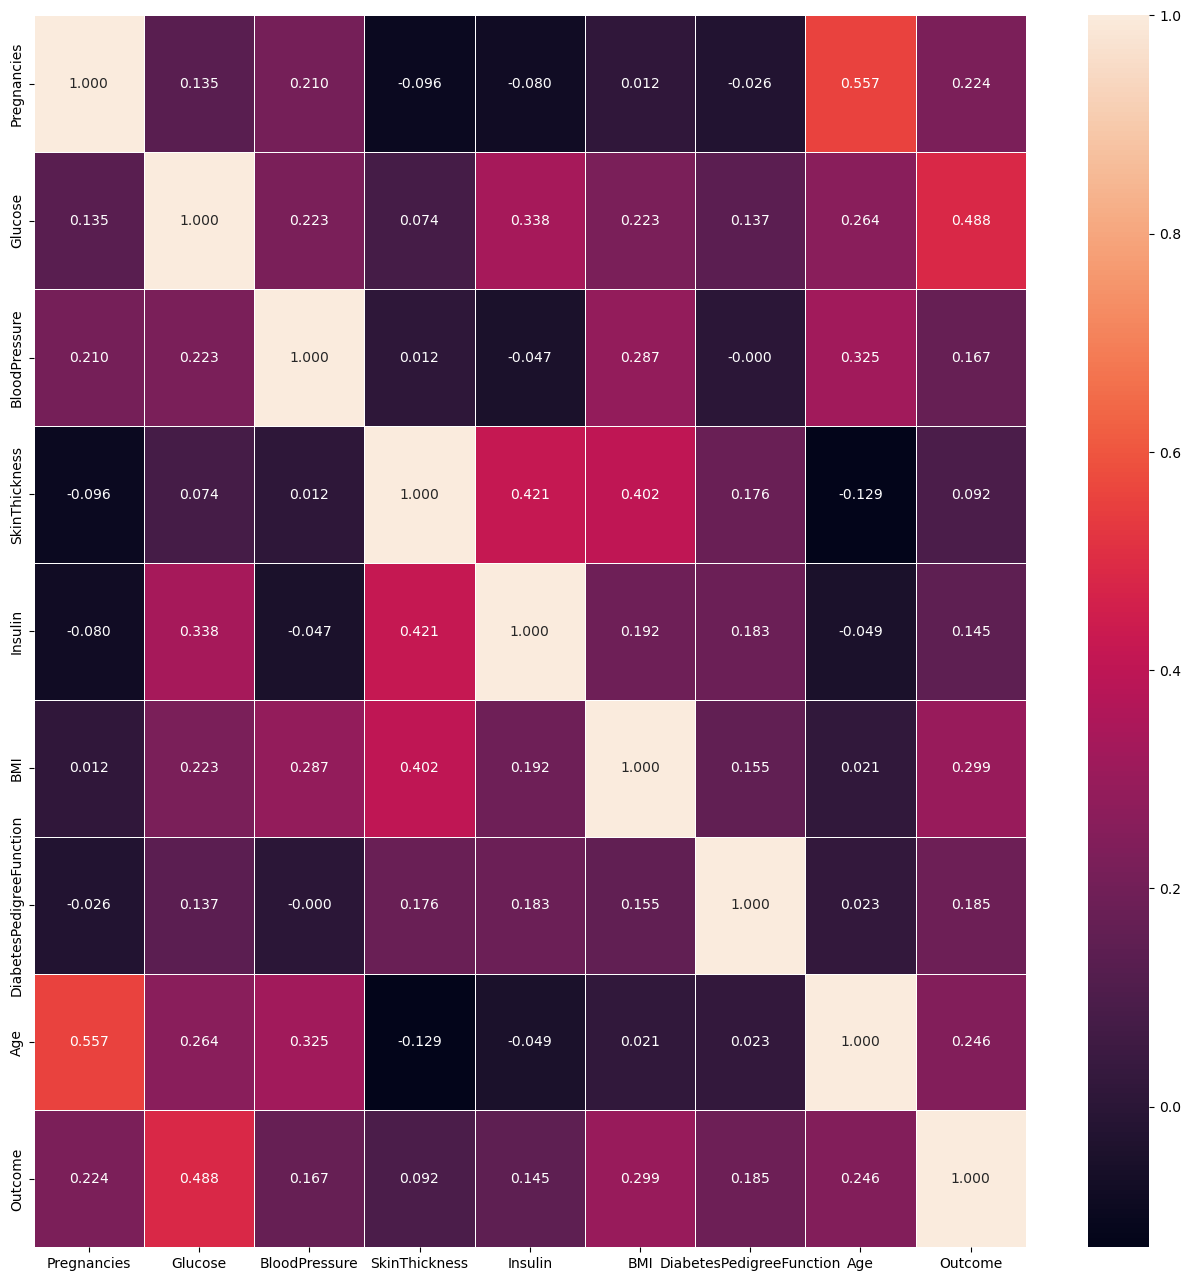

In [10]:
# Plot the correlation matrix

plt.figure(figsize = (16, 16))

_ = sns.heatmap(corr_matrix, annot = True, fmt = ".3f", linewidths = .5)

plt.show()

fig = _.get_figure()

fig.savefig('img/corr_mat_diabetes.png')

There are significant correlations between BMI and skin thickness, skin thickness and insulin, glucose and insulin, glucose and outcome, blood presure and age and blood presure and bmi. 

# Split the data into training and test sets

In [11]:
# split the dataframe into target and features

y = df["Outcome"] # target
X = df.drop(columns = ["Outcome"]) # features

# Verify that the split was performed correctly
print(X.shape)
print(y.shape)

(724, 8)
(724,)


In [12]:
# split the labels and features into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21, stratify = y)

# Verify that the split was performed correctly
print('Training set')
print(X_train.shape)
print(y_train.shape)
print()
print('Testing set')
print(X_test.shape)
print(y_test.shape)
print()

Training set
(579, 8)
(579,)

Testing set
(145, 8)
(145,)



In [13]:
# Verify that the index has been shuffled
print(X.index)
print()
print(X_train.index)

Index([  0,   1,   2,   3,   4,   5,   6,   8,  10,  11,
       ...
       758, 759, 760, 761, 762, 763, 764, 765, 766, 767],
      dtype='int64', length=724)

Index([271, 429, 477, 148,  39, 576, 617,  83, 618, 216,
       ...
       628, 105, 250, 537, 620, 119, 334, 727, 482, 724],
      dtype='int64', length=579)


# Train an XGBoost Classifier in scikit-learn

In [14]:
# import the classifier

from xgboost import XGBClassifier

In [15]:
xgb_classifier = XGBClassifier(objective = 'binary:logistic', 
                               eval_metric = 'error', 
                               learning_rate = 0.1,
                               max_depth = 8,
                               alpha = 25,
                               n_estimators = 100 
                               )

xgb_classifier.fit(X_train, y_train)

XGBClassifier(alpha=25, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

# Test the model

In [16]:
# predict the performance score of the trained model using the testing dataset

result = xgb_classifier.score(X_test, y_test)
print("Accuracy: {}".format(result))

Accuracy: 0.7586206896551724


In [17]:
# make predictions on the test data

y_predict = xgb_classifier.predict(X_test)
y_predict

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0])

In [18]:
# print the performance report

from sklearn.metrics import classification_report

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.75      0.94      0.84        95
           1       0.78      0.42      0.55        50

    accuracy                           0.76       145
   macro avg       0.77      0.68      0.69       145
weighted avg       0.76      0.76      0.74       145



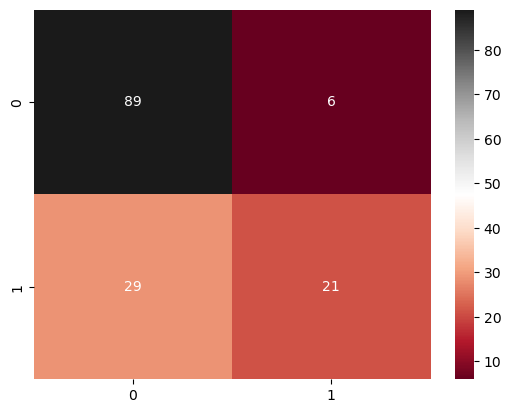

In [19]:
# print the confusion matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, fmt = 'd', annot = True, cmap = 'RdGy')

plt.savefig('img/conf_mat_diabetes.png')


In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score

In [21]:
selected_features = SelectKBest(chi2, k = 7).fit(X_train, y_train)

print('Score List: ', selected_features.scores_)
print()
print('Feature list: ', X_train.columns)

Score List:  [  54.74146102 1079.04188538   38.25432668  115.23908768 2364.91877118
   80.03689299    5.97908954  160.57987936]

Feature list:  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')


[0]	validation_0-error:0.34370	validation_1-error:0.34483
[1]	validation_0-error:0.34370	validation_1-error:0.34483
[2]	validation_0-error:0.34370	validation_1-error:0.34483
[3]	validation_0-error:0.34370	validation_1-error:0.34483
[4]	validation_0-error:0.34370	validation_1-error:0.34483
[5]	validation_0-error:0.34370	validation_1-error:0.34483
[6]	validation_0-error:0.34370	validation_1-error:0.34483
[7]	validation_0-error:0.34370	validation_1-error:0.34483
[8]	validation_0-error:0.34370	validation_1-error:0.34483
[9]	validation_0-error:0.34370	validation_1-error:0.34483
[10]	validation_0-error:0.34370	validation_1-error:0.34483
[11]	validation_0-error:0.34370	validation_1-error:0.34483
[12]	validation_0-error:0.34370	validation_1-error:0.34483
[13]	validation_0-error:0.34370	validation_1-error:0.34483
[14]	validation_0-error:0.34370	validation_1-error:0.34483
[15]	validation_0-error:0.34370	validation_1-error:0.34483
[16]	validation_0-error:0.34370	validation_1-error:0.34483
[17]	va

<Axes: >

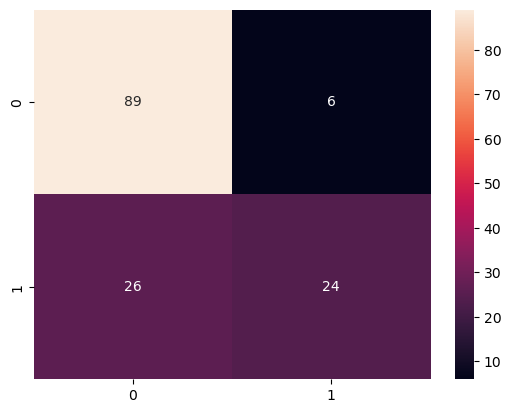

In [108]:
##### X_train_2 = selected_features.transform(X_train)

X_test_2 = selected_features.transform(X_test)

evalset = [(X_train_2, y_train), (X_test_2, y_test)]

xgb_classifier_2 = XGBClassifier(objective = 'binary:logistic', 
                                 eval_metric = 'error', 
                                 learning_rate = 0.01,
                                 max_depth = 8,
                                 alpha = 17,
                                 n_estimators = 300,                
                                 min_child_weight = 1,                                 
                                 scale_pos_weight = 1,
                                 use_label_encoder = False,
                                 seed = 21).fit(X_train_2, y_train, eval_set = evalset)

result2 = xgb_classifier_2.score(X_test_2, y_test)
print("Accuracy: {}".format(result2))

print()
print('Accuracy is: ', accuracy_score(y_test, xgb_classifier_2.predict(X_test_2)))
print()

cm_2 = confusion_matrix(y_test, xgb_classifier_2.predict(X_test_2))

sns.heatmap(cm_2, annot = True, fmt = 'd')

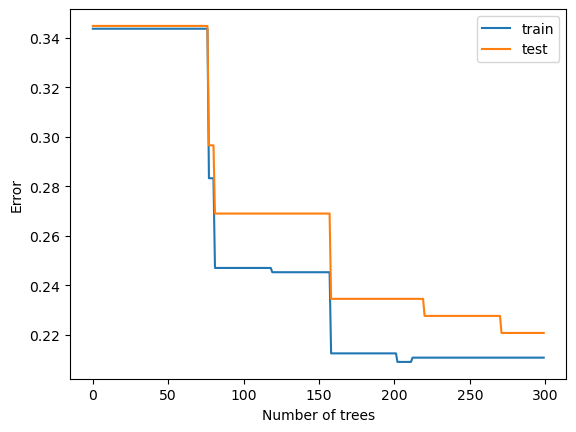

In [109]:
results = xgb_classifier_2.evals_result()

plt.plot(results['validation_0']['error'], label = 'train')
plt.plot(results['validation_1']['error'], label = 'test')

plt.xlabel('Number of trees')
plt.ylabel('Error')

plt.legend()

plt.show()

In [102]:
print(result2)

0.7793103448275862
